In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df_u = df['user_id'].unique()
df_u.shape[0]

290584

**d.** The proportion of users converted.

In [5]:
df.query("converted == 1").shape[0]/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page' or (group != 'treatment' and landing_page == 'new_page')").shape[0]

3893

**f.** Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### 2. For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. Use Quiz 2 in the classroom to provide how we should handle these rows.

In [8]:
df2 = df.drop(df[((df.group == 'treatment') & (df.landing_page == 'old_page')) | ((df.group == 'control') & (df.landing_page == 'new_page'))].index)

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df_uni = df2['user_id'].unique()
df_uni.shape[0]

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
duplicate_user = df2[df2['user_id'].duplicated()].user_id
duplicate_user

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df_user_dup = df2[df2["user_id"] == 773192]
df_user_dup

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
df2.drop_duplicates(['user_id'], inplace=True)
df2.shape

(290584, 5)

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [14]:
df2[df2.converted == 1].shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the control group, what is the probability they converted?

In [15]:
df_p = df2[df2.group == 'control']
control_converted = df_p[df2.converted == 1].shape[0]/df_p.shape[0]
control_converted

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df_p2 = df2[df2.group == 'treatment']
treatment_converted = df_p2[df2.converted == 1].shape[0]/df_p.shape[0]
treatment_converted

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1188375070556328

In [17]:
obs_diff = treatment_converted - control_converted
obs_diff

-0.0015487974448284009

**d.** What is the probability that an individual received the new page?

In [18]:
df2[df2.landing_page == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

#### **e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

We can't really tell from our data whether the new treatment page leads to more conversions or not, even the probability of conversion is lower in the treatment group than in the control group.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
 For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of  pold  and  pnew , which are the converted rates for the old and new pages.

### H0:pnew−pold≤0
### H0:pnew−pold>0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p_new = df2['converted'].sum() / len(df2)
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p_old = df2['converted'].sum() / len(df2)
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [21]:
n_new = df2[df2['landing_page'] == 'new_page']['landing_page'].count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2['landing_page'] == 'old_page']['landing_page'].count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [23]:
df_tr = df2.query('group == "treatment"')
new = df_tr.sample(n_new, replace=True)
new_page_converted = new['converted']
new_page_converted.mean()

0.11954442226963044

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
df_con = df2.query('group == "control"')
old = df_con.sample(n_old, replace=True)
old_page_converted = old['converted']
old_page_converted.mean()

0.12116414499497501

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
p_difference= new_page_converted.mean() - old_page_converted.mean()
p_difference

-0.0016197227253445662


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# Sampling distribution 
control_conv_prob = []
treatment_conv_prob = []
p_diffs = []
for _ in range(10000):
    old2 = df_con.sample(n_old, replace=True)
    new2 = df_tr.sample(n_new, replace=True)

    control_conversion = old2['converted'].sum() / n_old
    treatment_conversion = new2['converted'].sum() / n_new
    control_conv_prob.append(control_conversion)
    treatment_conv_prob.append(treatment_conversion)
    p_diffs.append(treatment_conversion - control_conversion)
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

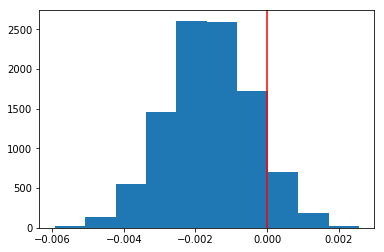

In [27]:
plt.hist(p_diffs);
plt.axvline(x=0, color='red');

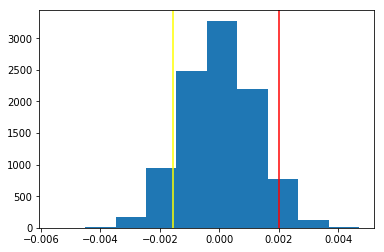

In [28]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='yellow');
plt.axvline(x=np.percentile(null_vals, 95), color='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
(p_diffs > obs_diff).mean()

0.47660000000000002

In [30]:
p_value = (null_vals > obs_diff).mean()
p_value

0.90249999999999997

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

### The value we called in scientific studies is the p-value. proportion of the p_diffs greater than the actual difference observed is 50%. the value signify that there is 90% probability of observing our conversion difference. we can't reject the null hypothesis with a type I error rate of 5%. we should stick with the old page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [ ]:
import statsmodels.api as sm

convert_old = df2.query('(group == "control") & (converted == 1)').count()
convert_new = df2.query('(group == "treatment") & (converted == 1)').count()
n_old = df2.query('group == "control"').count()
n_new = df2.query('group == "treatment"').count()

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  

In [35]:
import statsmodels.api as sm

count_array = [convert_new.iloc[0], convert_old.iloc[0]]
nobs_array = [n_new.iloc[0], n_old.iloc[0]]
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


In [36]:
from scipy.stats import norm

critical_value = norm.ppf(1 - (0.05))
critical_value

1.6448536269514722

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


### The p_value signify that there is 90% probability of observing our conversion difference. We should stick with the old page. The findings in the two parts agree.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

### Logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [37]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [38]:
logistic_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
lm_fit = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
lm_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-16 22:55 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  




The p-value associated with ab_page is 0.1899. And it differs from the value found in part2 baecause of the different hypotheses tested in the two parts.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

## Well it is a good idea to consider other factors to add into the regression model because it gives a new term for the model to use to fit the data and improves the fit. For sure adding more terms will improve the model whether the new term adds significant value to the model or not. And yes there is a disadvantage to adding additional terms into the regression model which is making it more likely to overfit the model to the training data.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [40]:
df_countries = pd.read_csv('./countries.csv')

In [41]:
df_merged = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
countries_dum = pd.get_dummies(df_merged['country'])
df_dum = countries_dum.join(df_merged, how='inner')
df_dum.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,0,1,0,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,0,1,0,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [ ]:
logistic_model2 = sm.Logit(df_dum['converted'], df_dum[['intercept', 'UK', 'CA']])
results = logistic_model2.fit()
results.summary()

### We can't tell whether the country had an impact on conversion or not (p-values are high), we need more variables to be able to predict.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 

In [43]:
UK_newpage = df_dum['ab_page'] * df_dum['UK']
df_dum['UK_newpage'] = UK_newpage
CA_newpage = df_dum['ab_page'] * df_dum['CA']
df_dum['CA_newpage'] = CA_newpage
df_dum.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page,UK_newpage,CA_newpage
user_id,,,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,0,1,0,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,0,1,0,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [45]:
logistic_model3 = sm.Logit(df_dum['converted'], df_dum[['intercept', 'ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage']])
lm_fit3 = logistic_model2.fit()
lm_fit3.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-16 22:55 AIC:              212782.9259
No. Observations:   290584           BIC:              212835.8241
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
CA           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
UK_newpage    0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA_newpage   -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
==================================================================

"""

###  p_values are higher than the I error rate (0.05), We can't reject the null and still we should stick with the old page.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

logistic_model4 = LogisticRegression()
logistic_model4.fit(df_dum[['ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage']], df_dum['converted'])
print(logistic_model4.intercept_)
print(logistic_model4.coef_)
X = df_dum[['ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage']]
y = df_dum['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

[-1.98629438]
[[-0.0207465  -0.00591686 -0.01746634  0.03156269 -0.04680308]]


In [50]:
logistic_model5 = LogisticRegression()
logistic_model5.fit(X_train, y_train)
preds = logistic_model5.predict(X_test)
print(logistic_model5.intercept_)
print(logistic_model5.coef_)

[-1.99119044]
[[-0.01611186  0.00275874 -0.01784459  0.01289915 -0.05392361]]


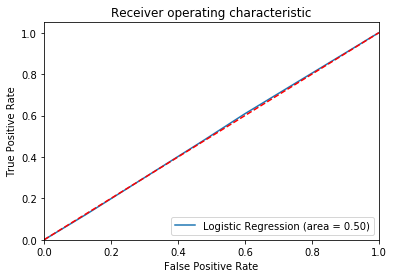

In [51]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logistic_model5.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logistic_model5.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 2.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# conclusion

### In many ways testing whether the new page increases conversions or not. and as a conclusion from all we have we believe that the new page isn't any better than the old page. And our data doesn't have enough evidence to prove that we need to swtch to the new page. therefore as a conclusion we need to stick with the old page based on the data we have in hand.

In [55]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0